# Digit Recognizer

MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.

The goal of this competition is to correctly identify digits from a dataset of tens of thousands of handwritten images.

[Kaggle - Digit Recognizer](https://www.kaggle.com/c/digit-recognizer)

## Dataset

- There are two datasets containing gray-scale images of hand-drawn digits (from 0 through 9), referred as __train__ and __test__.
- Each image is __28 pixels in height and 28 pixels in width__, for a __total of 784 pixels__. 
- Each __pixel has a single pixel-value (an integer between 0 and 255) associated, indicating the brightness__ of that pixel. Higher pixel-values means darker.

- The __training data set (train)__ has 785 columns. The __first column, called _label_, is the digit that was drawn by the user__. The __rest of the columns contain the pixel-values__ of the associated image.

- __Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783__. To locate this pixel on the image, suppose that x was decomposed as x = i * 28 + j, where i and j are integers between 0 and 27. Then __pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero)__.

- The __test data set (test)__ is the same as the training set, except that it __does not contain the _label_ column__.

## Setup

In [2]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization
from sklearn.preprocessing import LabelEncoder
import math
from mpl_toolkits.mplot3d import Axes3D

# Models
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn import decomposition
from sklearn import datasets
from sklearn.neural_network import MLPClassifier

## Data Processing

In [3]:
df_train = pd.read_csv('train.csv', low_memory = False)
df_test = pd.read_csv('test.csv', low_memory = False)

In [4]:
print(df_train.shape)
print(df_test.shape)

(42000, 785)
(28000, 784)


In [5]:
print(df_train.head())
print(df_test.head())

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0         

In [6]:
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB
None


In [7]:
df_train.columns[df_train.isnull().any()]

Index([], dtype='object')

In [8]:
df_test.columns[df_test.isnull().any()]

Index([], dtype='object')

__There are no NULL values on each dataset__

In [9]:
df_train["label"].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

## Data Visualization

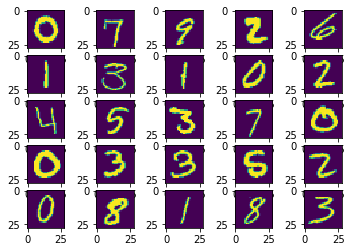

In [10]:
# plot the first 25 digits in the training set. 
f, ax = plt.subplots(5, 5)
# plot some 4s as an example
for i in range(1,26):
    # Create a 1024x1024x3 array of 8 bit unsigned integers
    data = df_train.iloc[i,1:785].values #this is the first number
    nrows, ncols = 28, 28
    grid = data.reshape((nrows, ncols))
    n=math.ceil(i/5)-1
    m=[0,1,2,3,4]*5
    ax[m[i-1], n].imshow(grid)

## PCA

There are many features in this data resulting in high dimensionality. PCA is used to compress the features into a small but informative set of features before using the data in a machine learning model. Data is normalized before PCA is applied. This is so the scale of the data does not throw of the PCA, and so the 0's are represented meaningfully. There is unequal variance in this data, and features with larger variance will influence the PCA more, creating bias. This is why the data is normalized.

In [11]:
# data normalization #
label_train=df_train['label']
df_train=df_train.drop('label', axis=1)

# 255 is the max pixel value
df_train = df_train / 255
df_test = df_test / 255
df_train['label'] = label_train

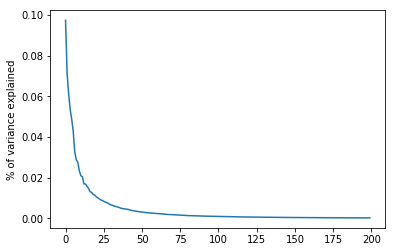

In [12]:
## PCA decomposition
pca = decomposition.PCA(n_components=200) #Finds first 200 PCs
pca.fit(df_train.drop('label', axis=1))
plt.plot(pca.explained_variance_ratio_)
plt.ylabel('% of variance explained')
#plot reaches asymptote at around 50, which is optimal number of PCs to use. 

## PCA decomposition with optimal number of PCs
#decompose train data
pca = decomposition.PCA(n_components=100) #use first 3 PCs (update to 100 later)
pca.fit(df_train.drop('label', axis=1))
PCtrain = pd.DataFrame(pca.transform(df_train.drop('label', axis=1)))
PCtrain['label'] = df_train['label']

#decompose test data
#pca.fit(test)
PCtest = pd.DataFrame(pca.transform(df_test))

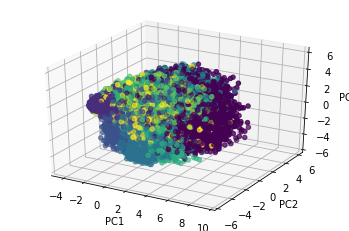

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax = fig.add_subplot(111)

x =PCtrain[0]
y =PCtrain[1]
z =PCtrain[2]

colors = [int(i % 9) for i in PCtrain['label']]
ax.scatter(x, y, z, c=colors, marker='o', label=colors)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()

## Neural Network

In [15]:
y = PCtrain['label'][0:20000]
X=PCtrain.drop('label', axis=1)[0:20000]
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(3500,), random_state=1)
clf.fit(X, y)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(3500,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [16]:
#accuracy and confusion matrix
predicted = clf.predict(PCtrain.drop('label', axis=1)[20001:42000])
expected = PCtrain['label'][20001:42000]

print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Classification report for classifier MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(3500,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2200
           1       0.99      0.99      0.99      2418
           2       0.97      0.97      0.97      2167
           3       0.97      0.95      0.96      2270
           4       0.97      0.97      0.97      2101
           5       0.97      0.97      0.97      2001
           6       0.98      0.98      0.98      2155
           7       0.97      0.98      0.97      2331
           8       0.9

In [20]:
output = pd.DataFrame(clf.predict(PCtest), columns =['Label'])
output.reset_index(inplace=True)
output.rename(columns={'index': 'ImageId'}, inplace=True)
output['ImageId']=output['ImageId']+1
output.to_csv('output.csv', index=False)

In [21]:
output

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
5,6,9
6,7,0
7,8,3
8,9,0
9,10,3


## References

- https://www.kaggle.com/shivamb/a-very-comprehensive-tutorial-nn-cnn/notebook
- https://www.kaggle.com/statinstilettos/neural-network-approach
- https://www.kaggle.com/ancientaxe/simple-neural-network-from-scratch-in-python